# LGBM Draft (Refactored)

Sections: data cleaning, feature engineering, dataset prep, model build, training, evaluation.


In [539]:
import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [540]:
# Optional: set repo root manually
# repo_root = Path('C:/Users/BaiYang/CBOND_DAY')
repo_root = None

root = Path.cwd()
if repo_root is None:
    while root != root.parent and not (root / 'cbond_daily').exists():
        root = root.parent
    if not (root / 'cbond_daily').exists():
        raise FileNotFoundError('Cannot find repo root containing cbond_daily. Set repo_root explicitly.')
else:
    root = repo_root

# Load paths_config.json5 (minimal parsing)
paths_cfg = root / 'cbond_daily' / 'config' / 'paths_config.json5'
text = paths_cfg.read_text(encoding='utf-8')

m = re.search(r'dwd_root\s*:\s*"([^"]+)"', text)
if not m:
    raise ValueError('Cannot parse dwd_root from paths_config.json5')

dwd_root = Path(m.group(1))
print('dwd_root:', dwd_root)


dwd_root: D:\cbond_daily\clean_data


In [541]:
# Settings
import warnings
warnings.filterwarnings('ignore')

# date range
start = '2024-01-01'
end = '2026-01-12'

# label uses t+1 prices
buy_twap_col = 'twap_0945_1000'
sell_twap_col = 'twap_1430_1442'

# label / clip
Y_COL = 'y'
USE_Y_CLIP = True
Y_CLIP_Q = (0.01, 0.99)

USE_Y_ZSCORE = True

# data cleaning
CLEAN_REQUIRED_COLS = [
    'trade_date', 'code',
    'close_price', 'prev_close_price', 'amount',
    'base_bond_prem_ratio', 'base_stk_close_price',
    'base_year_to_mat', 'base_ytm',
    'base_in_trigger_process', 'base_conv_value', 'base_pure_redemption_value',
    buy_twap_col, sell_twap_col,
]
CLEAN_PLOT_COLS = ['close_price']

# feature engineering toggles

# feature clip
USE_FEATURE_CLIP = True
FEATURE_CLIP_Q = (0.01, 0.99)

USE_LOG_FEATURES = True
USE_EMA_FEATURES = True
USE_INTERACTION_FEATURES = True
USE_RANK_FEATURES = True
USE_ZSCORE = True

# feature enhancement settings
EMA_SPANS = [5, 10, 20, 40, 80, 160]
EMA_COLS = ['close_price', 'amount', 'base_bond_prem_ratio', 'base_ytm']
INTERACTION_PAIRS = [
    ('base_bond_prem_ratio', 'base_ytm'),
    ('base_bond_prem_ratio', 'base_year_to_mat'),
    ('ret_1d', 'base_bond_prem_ratio'),
    ('ovr', 'base_ytm'),
]
RANK_COLS = [
    'close_price', 'amount', 'base_bond_prem_ratio', 'base_ytm',
    'ret_1d', 'ovr', 'stk_ret_1d'
]

# feature plotting
FE_PLOT_COLS = ['ret_1d']
PLOT_TOPN_FEATURES = True
TOPN_FEATURES = 5

# dataset split
TRAIN_RATIO = 0.6
VAL_RATIO = 0.2

# model build
MODEL_NAME = 'lgbm'
MODEL_PARAMS = {
    'objective': 'regression',
    'learning_rate': 0.02,
    'num_leaves': 63,
    'max_depth': 4,
    'min_data_in_leaf': 50,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'lambda_l1': 0.001,
    'lambda_l2': 0.001,
    'n_estimators': 1000,
    'random_state': 42,
    'verbose': -1,
}

# GPU settings (set True if LightGBM GPU build is installed)
USE_GPU = True

# training modes: 'fixed' | 'optuna' | 'optuna_replay'
TRAIN_MODE = 'optuna_replay'
EARLY_STOPPING_ROUNDS = 1000


# optuna parameter space
OPTUNA_PARAM_SPACE = {
    'lambda_l1': {'type': 'float', 'low': 1e-6, 'high': 10.0, 'log': True},
    'lambda_l2': {'type': 'float', 'low': 1e-6, 'high': 10.0, 'log': True},
    'n_estimators': {'type': 'int', 'low': 1000, 'high': 2000, 'step': 200},
    'max_depth': {'type': 'int', 'low': 4, 'high': 16},
    'num_leaves': {'type': 'int', 'low': 16, 'high': 128, 'step': 16},
    'min_data_in_leaf': {'type': 'int', 'low': 20, 'high': 500, 'step': 20},
    # 'feature_fraction': {'type': 'float', 'low': 0.6, 'high': 1.0},
    # 'bagging_fraction': {'type': 'float', 'low': 0.6, 'high': 1.0},
    # 'bagging_freq': {'type': 'int', 'low': 0, 'high': 10},
}

# optuna settings
OPTUNA_TRIALS = 100
OPTUNA_METRIC = 'acc'  # 'mse' (min), 'r2' (max), 'acc' (max)
OPTUNA_RESULTS_PATH = 'results/optuna_best_params.json'

# evaluation
BIN_COUNT = 20
PLOT_DAILY_METRICS = True


## 1) Data Cleaning


rows: 447707
available columns: ['trade_date', 'code', 'close_price', 'prev_close_price', 'amount', 'base_bond_prem_ratio', 'base_stk_close_price', 'base_year_to_mat', 'base_ytm', 'base_in_trigger_process', 'base_conv_value', 'base_pure_redemption_value', 'twap_0945_1000', 'twap_1430_1442']


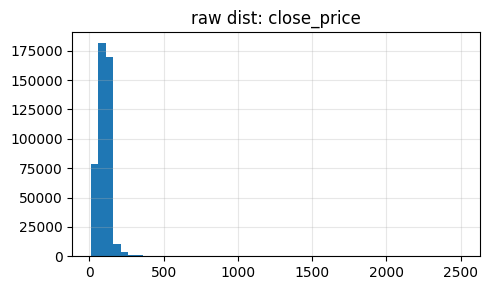

In [542]:
# Load cleaned data range
from datetime import datetime

def read_clean_range(root: Path, start_date: str, end_date: str) -> pd.DataFrame:
    frames = []
    for day in pd.date_range(start_date, end_date, freq='D'):
        month = f"{day.year:04d}-{day.month:02d}"
        path = root / month / f"{day.strftime('%Y%m%d')}.parquet"
        if path.exists():
            frames.append(pd.read_parquet(path))
    if not frames:
        return pd.DataFrame()
    return pd.concat(frames, ignore_index=True)

raw = read_clean_range(dwd_root, start, end)
print('rows:', len(raw))

# check required columns
missing = [c for c in CLEAN_REQUIRED_COLS if c not in raw.columns]
if missing:
    raise KeyError(f'missing columns: {missing}')

work = raw[CLEAN_REQUIRED_COLS].copy()
work['trade_date'] = pd.to_datetime(work['trade_date']).dt.date

print('available columns:', list(work.columns))

# plot raw feature distributions (whitelist)
for col in CLEAN_PLOT_COLS:
    if col in work.columns:
        plt.figure(figsize=(5, 3))
        work[col].hist(bins=50)
        plt.title(f'raw dist: {col}')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()


## 2) Feature Engineering


feature count: 53
feature sample: ['close_price', 'prev_close_price', 'amount', 'base_bond_prem_ratio', 'base_stk_close_price', 'base_year_to_mat', 'base_ytm', 'base_in_trigger_process', 'base_conv_value', 'base_pure_redemption_value']


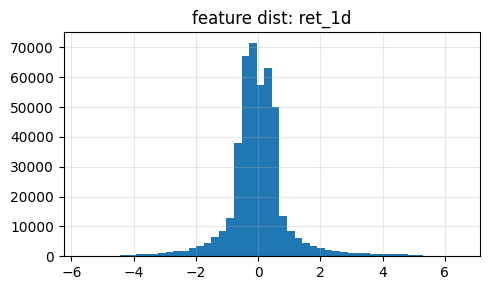

In [543]:
# base features
base_cols = [
    'close_price', 'prev_close_price', 'amount',
    'base_bond_prem_ratio', 'base_stk_close_price',
    'base_year_to_mat', 'base_ytm',
    'base_in_trigger_process', 'base_conv_value', 'base_pure_redemption_value'
]

# derived features
work['ret_1d'] = work['close_price'] / work['prev_close_price'] - 1.0
work['opt_value'] = work['close_price'] - work['base_pure_redemption_value']
work['ovr'] = work['opt_value'] / work['base_conv_value'].replace(0.0, np.nan)
work['stk_ret_1d'] = work['base_stk_close_price'] / work.groupby('code')['base_stk_close_price'].shift(1) - 1.0

# log features
log_cols = []
if USE_LOG_FEATURES:
    for col in ['amount', 'base_conv_value', 'base_pure_redemption_value', 'close_price']:
        log_col = f'log_{col}'
        work[log_col] = np.log1p(work[col].clip(lower=0))
        log_cols.append(log_col)

# EMA features (by code)
ema_cols = []
if USE_EMA_FEATURES:
    for col in EMA_COLS:
        if col not in work.columns:
            raise KeyError(f'EMA column missing: {col}')
        for span in EMA_SPANS:
            ema_col = f'ema_{col}_{span}'
            work[ema_col] = work.groupby('code')[col].transform(
                lambda s: s.ewm(span=span, adjust=False).mean()
            )
            ema_cols.append(ema_col)

# interaction features
interaction_cols = []
if USE_INTERACTION_FEATURES:
    for a, b in INTERACTION_PAIRS:
        if a not in work.columns or b not in work.columns:
            raise KeyError(f'interaction columns missing: {a}, {b}')
        col = f'{a}_x_{b}'
        work[col] = work[a] * work[b]
        interaction_cols.append(col)

# rank features
rank_cols = []
if USE_RANK_FEATURES:
    for col in RANK_COLS:
        if col not in work.columns:
            raise KeyError(f'rank column missing: {col}')
        rcol = f'rank_{col}'
        work[rcol] = work.groupby('trade_date')[col].rank(pct=True)
        rank_cols.append(rcol)

feature_cols = (
    base_cols
    + ['ret_1d', 'opt_value', 'ovr', 'stk_ret_1d']
    + log_cols
    + ema_cols
    + interaction_cols
    + rank_cols
)


# clip features by trade_date (winsorize)
if USE_FEATURE_CLIP:
    def _clip_feature(s: pd.Series) -> pd.Series:
        low, high = s.quantile(FEATURE_CLIP_Q[0]), s.quantile(FEATURE_CLIP_Q[1])
        return s.clip(lower=low, upper=high)

    clip_cols = [c for c in feature_cols if not c.startswith('rank_')]
    for col in clip_cols:
        work[col] = work.groupby('trade_date')[col].transform(_clip_feature)

# zscore by trade_date (no leakage)
if USE_ZSCORE:
    for col in feature_cols:
        work[col] = work.groupby('trade_date')[col].transform(lambda s: (s - s.mean()) / s.std(ddof=0))

work.replace([np.inf, -np.inf], np.nan, inplace=True)

print('feature count:', len(feature_cols))
print('feature sample:', feature_cols[:10])

# plot feature distributions after engineering (whitelist)
for col in FE_PLOT_COLS:
    if col in work.columns:
        plt.figure(figsize=(5, 3))
        work[col].hist(bins=50)
        plt.title(f'feature dist: {col}')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()


## 3) Dataset Preparation


In [544]:
# Build label y(t+1)
work['buy_twap_t1'] = work.groupby('code')[buy_twap_col].shift(-1)
work['sell_twap_t1'] = work.groupby('code')[sell_twap_col].shift(-1)
work['y'] = work['sell_twap_t1'] / work['buy_twap_t1'] - 1.0

# clip y by daily quantiles (winsorize)
if USE_Y_CLIP:
    def _clip_by_date(s: pd.Series) -> pd.Series:
        low, high = s.quantile(Y_CLIP_Q[0]), s.quantile(Y_CLIP_Q[1])
        return s.clip(lower=low, upper=high)

    work['y_raw'] = work['y']
    work['y'] = work.groupby('trade_date')['y'].transform(_clip_by_date)


# zscore y by trade_date
if USE_Y_ZSCORE:
    work['y'] = work.groupby('trade_date')['y'].transform(lambda s: (s - s.mean()) / s.std(ddof=0))

# build model_df
base_cols = ['trade_date', 'code'] + feature_cols + ['y']
if 'y_raw' in work.columns:
    base_cols.append('y_raw')
model_df = work[base_cols].dropna()
print('model rows:', len(model_df))

# Time split: train/val/test by date
all_days = sorted(model_df['trade_date'].unique())
if len(all_days) < 10:
    raise ValueError('not enough days for split')

n = len(all_days)
train_end = int(n * TRAIN_RATIO)
val_end = int(n * (TRAIN_RATIO + VAL_RATIO))

train_days = set(all_days[:train_end])
val_days = set(all_days[train_end:val_end])
test_days = set(all_days[val_end:])

train_df = model_df[model_df['trade_date'].isin(train_days)]
val_df = model_df[model_df['trade_date'].isin(val_days)]
test_df = model_df[model_df['trade_date'].isin(test_days)]

print('train/val/test rows:', len(train_df), len(val_df), len(test_df))


model rows: 174451
train/val/test rows: 111826 33297 29328


## 4) Model Build


In [545]:
import lightgbm as lgb

# apply GPU config
params = dict(MODEL_PARAMS)
if USE_GPU:
    params.update({
        'device': 'gpu',
        'gpu_platform_id': 0,
        'gpu_device_id': 0,
    })

def build_model(name: str, params: dict):
    if name == 'lgbm':
        return lgb.LGBMRegressor(**params)
    raise ValueError(f'unsupported model: {name}')


## 5) Model Training


In [546]:
from sklearn.metrics import mean_squared_error, r2_score

X_train = train_df[feature_cols]
y_train = train_df[Y_COL]
X_val = val_df[feature_cols]
y_val = val_df[Y_COL]
X_test = test_df[feature_cols]
y_test = test_df[Y_COL]

best_params = dict(params)

if TRAIN_MODE == 'optuna':
    try:
        import optuna
    except ImportError as exc:
        raise ImportError('optuna is not installed. Run: pip install optuna') from exc

    def objective(trial):
        trial_params = dict(params)
        for name, cfg in OPTUNA_PARAM_SPACE.items():
            if cfg['type'] == 'float':
                trial_params[name] = trial.suggest_float(
                    name, cfg['low'], cfg['high'], log=cfg.get('log', False)
                )
            elif cfg['type'] == 'int':
                trial_params[name] = trial.suggest_int(
                    name, cfg['low'], cfg['high'], step=cfg.get('step', 1)
                )
            else:
                raise ValueError(f"unsupported optuna param type: {cfg['type']}")
        model = build_model(MODEL_NAME, trial_params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='l2',
            callbacks=[lgb.log_evaluation(0)],
        )
        pred = model.predict(X_val)
        mse = float(mean_squared_error(y_val, pred))
        r2 = float(r2_score(y_val, pred))
        acc = float((np.sign(pred) == np.sign(y_val)).mean())

        if OPTUNA_METRIC == 'mse':
            return mse
        if OPTUNA_METRIC == 'r2':
            return r2
        if OPTUNA_METRIC == 'acc':
            return acc
        raise ValueError(f'unsupported OPTUNA_METRIC: {OPTUNA_METRIC}')

    direction = 'minimize' if OPTUNA_METRIC == 'mse' else 'maximize'
    study = optuna.create_study(direction=direction)
    study.optimize(objective, n_trials=OPTUNA_TRIALS, show_progress_bar=True)

    best_params = dict(params)
    best_params.update(study.best_params)

    out_dir = root / 'results'
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / Path(OPTUNA_RESULTS_PATH).name
    payload = {
        'best_params': study.best_params,
        'best_value': float(study.best_value),
        'metric': OPTUNA_METRIC,
    }
    out_path.write_text(json.dumps(payload, ensure_ascii=False, indent=2), encoding='utf-8')
    print('saved best params:', out_path)

elif TRAIN_MODE == 'optuna_replay':
    results_path = Path(OPTUNA_RESULTS_PATH)
    if not results_path.is_absolute():
        results_path = root / results_path
    if not results_path.exists():
        raise FileNotFoundError(f'optuna results not found: {results_path}')
    payload = json.loads(results_path.read_text(encoding='utf-8'))
    best_params = dict(params)
    best_params.update(payload.get('best_params', {}))

# train final model
model = build_model(MODEL_NAME, best_params)
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_names=['train', 'val'],
    eval_metric='l2',
    callbacks=[
        lgb.early_stopping(EARLY_STOPPING_ROUNDS, verbose=False),
        lgb.log_evaluation(0),
    ],
)

best_iter = model.best_iteration_ if model.best_iteration_ is not None else model.n_estimators
print('best_iteration:', best_iter)

pred_val = model.predict(X_val, num_iteration=best_iter)
pred_test = model.predict(X_test, num_iteration=best_iter)


best_iteration: 21


## 6) Evaluation


{'best_iteration': 21, 'val_r2': 0.0015358720434788253, 'val_rmse': 0.9962929876158526, 'test_r2': 0.002286206857304851, 'test_rmse': 0.9779139106393072, 'val_dir_acc': 0.4992942307114755, 'test_dir_acc': 0.5110474631751227}


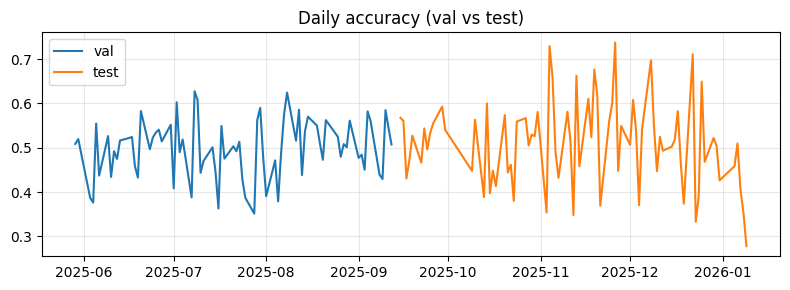

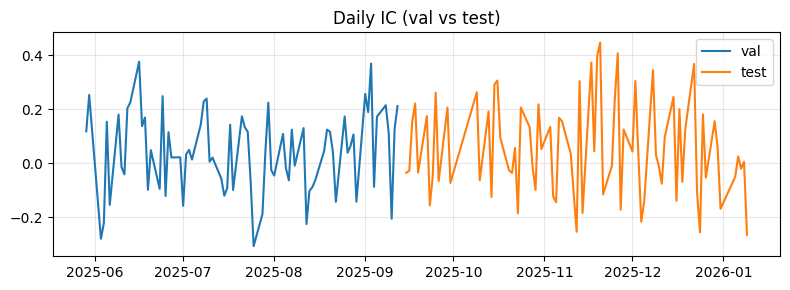

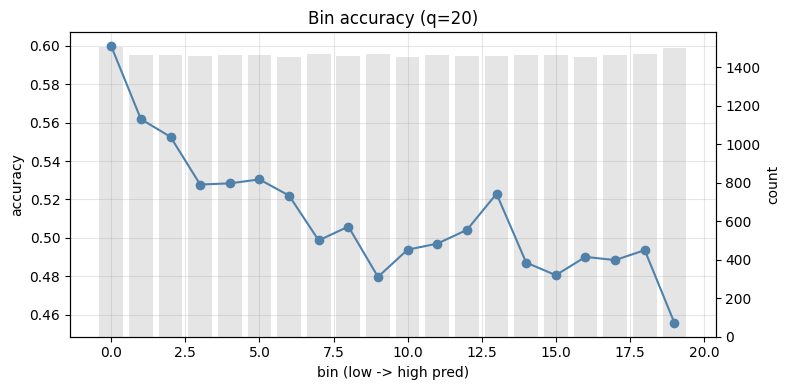

bin value counts: {0: 1507, 1: 1463, 2: 1464, 3: 1459, 4: 1463, 5: 1463, 6: 1456, 7: 1470, 8: 1459, 9: 1472, 10: 1452, 11: 1467, 12: 1458, 13: 1461, 14: 1466, 15: 1463, 16: 1455, 17: 1462, 18: 1469, 19: 1499}
daily sample size stats: {'count': 77.0, 'mean': 380.8831168831169, 'std': 13.997155750529448, 'min': 360.0, '25%': 368.0, '50%': 382.0, '75%': 394.0, 'max': 407.0}
base_in_trigger_process    255
ret_1d                      68
ovr_x_base_ytm              61
amount                      53
ema_amount_5                50
dtype: int32


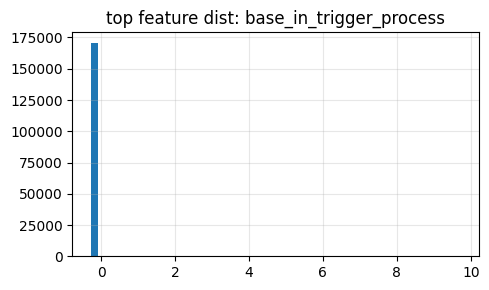

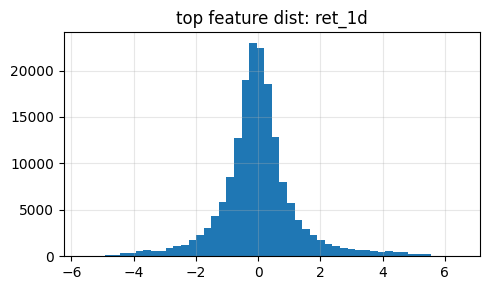

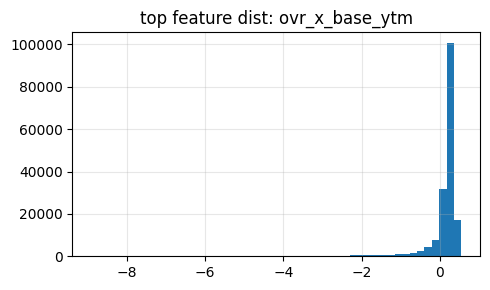

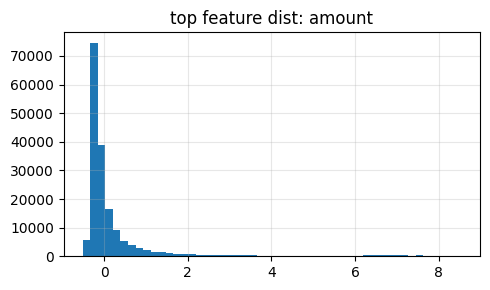

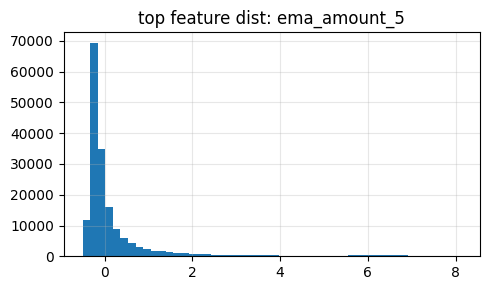

In [547]:
from sklearn.metrics import mean_squared_error, r2_score

# overall metrics
val_dir_acc = float((np.sign(pred_val) == np.sign(y_val)).mean())
test_dir_acc = float((np.sign(pred_test) == np.sign(y_test)).mean())

metrics = {
    'best_iteration': int(best_iter),
    'val_r2': r2_score(y_val, pred_val),
    'val_rmse': mean_squared_error(y_val, pred_val) ** 0.5,
    'test_r2': r2_score(y_test, pred_test),
    'test_rmse': mean_squared_error(y_test, pred_test) ** 0.5,
    'val_dir_acc': val_dir_acc,
    'test_dir_acc': test_dir_acc,
}
print(metrics)

# daily metrics (accuracy + IC)
val_eval = val_df[['trade_date']].copy()
val_eval['y'] = y_val.values
val_eval['pred'] = pred_val
val_eval['sign_hit'] = (np.sign(val_eval['pred']) == np.sign(val_eval['y'])).astype(int)

test_eval = test_df[['trade_date']].copy()
test_eval['y'] = y_test.values
test_eval['pred'] = pred_test
test_eval['sign_hit'] = (np.sign(test_eval['pred']) == np.sign(test_eval['y'])).astype(int)

def _daily_ic(df):
    if df['pred'].nunique() <= 1:
        return np.nan
    return df['pred'].corr(df['y'])

daily_val = val_eval.groupby('trade_date').apply(
    lambda g: pd.Series({
        'acc': g['sign_hit'].mean(),
        'ic': _daily_ic(g),
    })
).reset_index()

daily_test = test_eval.groupby('trade_date').apply(
    lambda g: pd.Series({
        'acc': g['sign_hit'].mean(),
        'ic': _daily_ic(g),
    })
).reset_index()

if PLOT_DAILY_METRICS:
    plt.figure(figsize=(8, 3))
    plt.plot(daily_val['trade_date'], daily_val['acc'], label='val')
    plt.plot(daily_test['trade_date'], daily_test['acc'], label='test')
    plt.title('Daily accuracy (val vs test)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 3))
    plt.plot(daily_val['trade_date'], daily_val['ic'], label='val')
    plt.plot(daily_test['trade_date'], daily_test['ic'], label='test')
    plt.title('Daily IC (val vs test)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# bin analysis by prediction (accuracy per bin, on test set)
df_bins = test_df[['trade_date', 'code']].copy()
df_bins['y'] = y_test.values
df_bins['pred'] = pred_test

def _assign_bins(day_df):
    if len(day_df) < BIN_COUNT:
        return None
    day_df = day_df.copy()
    # rank to [0,1], then cut into fixed bins
    day_df['pred_rank'] = day_df['pred'].rank(pct=True)
    bins = pd.cut(day_df['pred_rank'], bins=BIN_COUNT, labels=False, include_lowest=True)
    if bins is None or bins.isna().all():
        return None
    day_df['bin'] = bins
    day_df['sign_hit'] = (np.sign(day_df['pred']) == np.sign(day_df['y'])).astype(int)
    return day_df

parts = []
for d, g in df_bins.groupby('trade_date'):
    out = _assign_bins(g)
    if out is not None and 'bin' in out.columns:
        parts.append(out)

if not parts:
    print('no valid days for binning')
else:
    df_bins = pd.concat(parts, ignore_index=True)
    grouped = df_bins.groupby('bin').agg(
        acc=('sign_hit', 'mean'),
        count=('sign_hit', 'size'),
    ).reset_index()

    fig, ax1 = plt.subplots(figsize=(8, 4))
    ax1.plot(grouped['bin'], grouped['acc'], marker='o', color='steelblue')
    ax1.set_xlabel('bin (low -> high pred)')
    ax1.set_ylabel('accuracy')
    ax1.set_title(f'Bin accuracy (q={BIN_COUNT})')
    ax1.grid(True, alpha=0.3)

    ax2 = ax1.twinx()
    ax2.bar(grouped['bin'], grouped['count'], alpha=0.2, color='gray')
    ax2.set_ylabel('count')
    plt.tight_layout()
    plt.show()

    
    # diagnostics
    print('bin value counts:', df_bins['bin'].value_counts().sort_index().to_dict())
    print('daily sample size stats:', df_bins.groupby('trade_date').size().describe().to_dict())
# feature importance (top N) and distributions
importances = pd.Series(model.feature_importances_, index=feature_cols).sort_values(ascending=False)
print(importances.head(TOPN_FEATURES))

if PLOT_TOPN_FEATURES:
    top_cols = importances.head(TOPN_FEATURES).index.tolist()
    for col in top_cols:
        plt.figure(figsize=(5, 3))
        model_df[col].hist(bins=50)
        plt.title(f'top feature dist: {col}')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
